In [2]:
import pandas as pd
from geopy.geocoders import Photon
from geopy.geocoders import Nominatim
from unidecode import unidecode
import unidecode
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd


import matplotlib.pyplot as plt

This study utilized multiple data sources including migration events data from the National Institute of Migration, support institutions data from both governmental and civil sectors, and criminal incidence data. Additionally, geographic datasets from GIS and customs and border protection were incorporated to map the real-time movements and dynamics of migratory routes across Mexican borders.



In [67]:
dfvalores = pd.read_csv('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv')

In [187]:
dfvalores.columns

Index(['nombre', 'Ciudad', 'estado', 'geometry_xy', 'codigo_ruta',
       'ID_Poligono', 'codigo_unico', 'eventos', 'eventos_in_grid', 'inm_30km',
       'inm_in_grid', 'inm_in_estado', 'sc_30km', 'sc_in_grid', 'sc_in_estado',
       'inm_30km_adjusted', 'sc_30km_adjusted', 'log_eventos_per_inm_30km',
       'log_eventos_per_sc_30km', 'norm_log_eventos_per_inm_30km',
       'norm_log_eventos_per_sc_30km', 'distance_km', 'rellenado'],
      dtype='object')

In [188]:
# Lista de columnas a mantener
columnas_a_mantener = ['nombre', 'Ciudad', 'estado', 'geometry_xy', 'codigo_ruta',
                       'ID_Poligono', 'codigo_unico', 'eventos', 'eventos_in_grid', 'inm_30km',
                       'inm_in_grid', 'inm_in_estado', 'sc_30km', 'sc_in_grid', 'sc_in_estado',
                       'distance_km', 'rellenado']

# Filtrar el DataFrame para mantener solo las columnas especificadas
dfvalores = dfvalores[columnas_a_mantener]

/var/folders/68/6zkv8z4j4rl6ds90br2rb7ph0000gn/T/ipykernel_14640/950041374.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<AxesSubplot:>

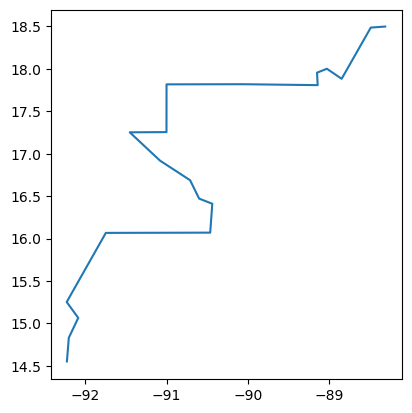

In [41]:
import geopandas as gpd
from shapely.ops import linemerge

# Cargar los datos de naturalearth_lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrar México, Guatemala y Belice
mexico = world[world.name == "Mexico"]
guatemala = world[world.name == "Guatemala"]
belize = world[world.name == "Belize"]

# Obtener las geometrías de los países
mexico_geom = mexico.geometry.iloc[0]
guatemala_geom = guatemala.geometry.iloc[0]
belize_geom = belize.geometry.iloc[0]

# Intersectar las fronteras
frontera_sur_guatemala = mexico_geom.intersection(guatemala_geom)
frontera_sur_belize = mexico_geom.intersection(belize_geom)

# Unir las fronteras en una sola geometría MultiLineString
frontera_sur_multilinestring = frontera_sur_guatemala.union(frontera_sur_belize)

# Convertir MultiLineString a LineString usando linemerge
frontera_sur_linestring = linemerge(frontera_sur_multilinestring)

# Crear un GeoDataFrame con la frontera sur unida en una fila y en formato LineString
fronteras_sur = gpd.GeoDataFrame(geometry=[frontera_sur_linestring], crs=world.crs)

# Mostrar la geometría en el mapa
fronteras_sur.plot()


In [87]:
# Function to convert string to Point object and invert latitude and longitude
def convert_and_invert_lat_lon(geometry_str):
    if isinstance(geometry_str, str):
        # Convert the string to a tuple of coordinates
        coords = eval(geometry_str.replace('POINT ', ''))
        # Create a Point object
        point = Point(coords)
    else:
        point = geometry_str
    
    # Invert latitude and longitude
    return Point(point.y, point.x)

# Apply the function to the geometry_xy column and overwrite the existing column
dfvalores['geometry_xy'] = dfvalores['geometry_xy'].apply(convert_and_invert_lat_lon)


In [189]:
dfvalores.head(2)

,nombre,Ciudad,estado,geometry_xy,codigo_ruta,ID_Poligono,codigo_unico,eventos,eventos_in_grid,inm_30km,inm_in_grid,inm_in_estado,sc_30km,sc_in_grid,sc_in_estado,distance_km,rellenado
0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,POINT (-92.2609265 14.9042905),S,PG1530,S-PG1530-8,98486,142180,2,4,13,17,11,35,11.8,False
1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,POINT (-93.6634408051158 17.7620967),G,PG1456,G-PG1456-1,97523,97523,0,0,3,0,0,0,302.0,False


In [116]:
# Google Maps API key
api_key = ''


In [75]:
import requests
import pandas as pd
from shapely.geometry import Point, LineString
import polyline

In [190]:
# Guardar el DataFrame en el archivo CSV especificado
#dfvalores.to_csv('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv', index=False)


In [213]:
# Calcular el promedio de distance_km por estado
#promedios_estado = dfvalores.groupby('estado')['distance_km'].mean()

# Crear una columna para identificar las filas rellenadas
#dfvalores['rellenado'] = False

# Rellenar las celdas NaN con el promedio correspondiente y marcar las filas rellenadas
#dfvalores.loc[dfvalores['distance_km'].isna(), 'distance_km'] = dfvalores[dfvalores['distance_km'].isna()].apply(
#    lambda row: promedios_estado[row['estado']], axis=1)

#dfvalores.loc[dfvalores['distance_km'].isna(), 'rellenado'] = True

# Mostrar el DataFrame actualizado
#print(dfvalores[['nombre', 'ciudad', 'estado', 'distance_km', 'rellenado']])


In [95]:
import requests
import pandas as pd
from shapely.geometry import Point, LineString
import polyline

# Function to convert distances to kilometers
def convert_distance_to_km(distance):
    if distance is None:
        return None
    if 'km' in distance:
        return float(distance.replace(' km', '').replace(',', ''))
    elif 'mi' in distance:
        return float(distance.replace(' mi', '').replace(',', '')) * 1.60934  # Conversion from miles to kilometers
    else:
        return None

# Function to validate coordinates
def valid_coordinates(lat, lon):
    return -90 <= lat <= 90 and -180 <= lon <= 180

# Function to get the distance from the Google Maps API
#def obtener_distancia_google_maps(point, nearest_point, api_key):
    if not (valid_coordinates(point.y, point.x) and valid_coordinates(nearest_point.y, nearest_point.x)):
        print(f"Invalid coordinates: {point.y},{point.x} or {nearest_point.y},{nearest_point.x}")
        return None

    base_url = "https://maps.googleapis.com/maps/api/directions/json"
    modes = ['walking', 'driving']  # Try both walking and driving modes
    for mode in modes:
        params = {
            'origin': f"{point.y},{point.x}",
            'destination': f"{nearest_point.y},{nearest_point.x}",
            'mode': mode,
            'key': api_key
        }
        print(f"Requesting distance from {params['origin']} to {params['destination']} with mode {mode}")
        response = requests.get(base_url, params=params)
        result = response.json()
        print("API response:", result)

        if result['status'] == 'OK':
            distancia = result['routes'][0]['legs'][0]['distance']['text']
            distancia_km = convert_distance_to_km(distancia)
            return distancia_km
        else:
            print("Error in response:", result.get('status'))
            if result.get('status') == 'ZERO_RESULTS':
                continue  # Try the next mode if zero results
            else:
                return None
    return None

# Get the line from the fronteras_sur dataframe (assuming a single line)
line = fronteras_sur['geometry'].iloc[0]


# Find the nearest point on the border and calculate the distance for each point in dfvalores
dfvalores['distance_km'] = dfvalores['geometry_xy'].apply(
    lambda point: obtener_distancia_google_maps(point, line.interpolate(line.project(point)), api_key)
)

# Display the updated dataframe
print(dfvalores[['nombre', 'ciudad', 'estado', 'distance_km']])


nombre                            object
ciudad                            object
estado                            object
geometry_xy                       object
codigo_ruta                       object
ID_Poligono                       object
codigo_unico                      object
eventos                            int64
eventos_in_grid                    int64
inm_30km                           int64
inm_in_grid                        int64
inm_in_estado                      int64
sc_30km                            int64
sc_in_grid                         int64
sc_in_estado                       int64
inm_30km_adjusted                  int64
sc_30km_adjusted                   int64
log_eventos_per_inm_30km         float64
log_eventos_per_sc_30km          float64
norm_log_eventos_per_inm_30km    float64
norm_log_eventos_per_sc_30km     float64
distance_km                      float64
dtype: object
geometry    geometry
dtype: object
Requesting distance from 14.9042905,-92.2609265 t

/Users/pablouriarte/opt/anaconda3/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJhZKIeOAOjoUR2BX70r1cI84', 'types': ['premise']}, {'geocoder_status': 'OK', 'place_id': 'ChIJvaYlnacNjoURGkFSClQoj6U', 'types': ['route']}], 'routes': [{'bounds': {'northeast': {'lat': 14.9041426, 'lng': -92.18307879999999}, 'southwest': {'lat': 14.866776, 'lng': -92.26079770000001}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '11.8 km', 'value': 11787}, 'duration': {'text': '2 hours 40 mins', 'value': 9628}, 'end_address': 'Vía sin nombre, 30870 2da. Secc. de Medio Monte, Chis., Mexico', 'end_location': {'lat': 14.866776, 'lng': -92.18515459999999}, 'start_address': '5a. Priv. Sur 2B, Los Naranjos, Centro, 30830 Tapachula de Córdova y Ordóñez, Chis., Mexico', 'start_location': {'lat': 14.9041426, 'lng': -92.2605933}, 'steps': [{'distance': {'text': '54 m', 'value': 54}, 'duration': {'text': '1 min', 'value': 43}, 'end_location': {'lat': 14.9037031, 'lng': -92.26079770000001}, 'htm

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJQxVqBssO7IUR8nqzUCrsftI', 'types': ['route']}, {'geocoder_status': 'OK', 'place_id': 'ChIJwQT5cH9z84URtgehZ261FSM', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 17.8542768, 'lng': -91.4631146}, 'southwest': {'lat': 17.2120177, 'lng': -93.659043}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '302 km', 'value': 302340}, 'duration': {'text': '2 days 20 hours', 'value': 244741}, 'end_address': '29967 Chis., Mexico', 'end_location': {'lat': 17.2358014, 'lng': -91.4631146}, 'start_address': 'Tierra Nueva - Francisco Rueda, 86432 Tab., Mexico', 'start_location': {'lat': 17.7579773, 'lng': -93.659043}, 'steps': [{'distance': {'text': '5.2 km', 'value': 5237}, 'duration': {'text': '1 hour 10 mins', 'value': 4187}, 'end_location': {'lat': 17.7933995, 'lng': -93.62806289999999}, 'html_instructions': 'Head <b>northeast</b> on <b>Tierra Nueva - Francisco Rueda</b>', '

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJ1Tbt2K0K7oURrlFeqDuHorE', 'types': ['route']}, {'geocoder_status': 'OK', 'place_id': 'ChIJwQT5cH9z84URtgehZ261FSM', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 18.0482602, 'lng': -91.4631146}, 'southwest': {'lat': 17.2119201, 'lng': -92.8277686}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '214 km', 'value': 214398}, 'duration': {'text': '2 days 0 hours', 'value': 173527}, 'end_address': '29967 Chis., Mexico', 'end_location': {'lat': 17.2358014, 'lng': -91.4631146}, 'start_address': 'Vía sin nombre, 86278 Barrancas y Guanal González, Tab., Mexico', 'start_location': {'lat': 18.0383477, 'lng': -92.77471709999999}, 'steps': [{'distance': {'text': '8.6 km', 'value': 8606}, 'duration': {'text': '1 hour 55 mins', 'value': 6907}, 'end_location': {'lat': 18.0295268, 'lng': -92.8270402}, 'html_instructions': 'Head <b>west</b>', 'polyline': {'points': 'ubbmB~`gu

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJX4Rhi-cC6oUR_w0ULBSyeW8', 'types': ['street_address']}, {'geocoder_status': 'OK', 'place_id': 'ChIJwQT5cH9z84URtgehZ261FSM', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 18.1242015, 'lng': -91.4631146}, 'southwest': {'lat': 17.2150816, 'lng': -94.9146923}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '485 km', 'value': 484785}, 'duration': {'text': '4 days 13 hours', 'value': 392304}, 'end_address': '29967 Chis., Mexico', 'end_location': {'lat': 17.2358014, 'lng': -91.4631146}, 'start_address': 'C. Moctezuma 28, Centro, 96000 Acayucan, Ver., Mexico', 'start_location': {'lat': 17.9488041, 'lng': -94.9146923}, 'steps': [{'distance': {'text': '50 m', 'value': 50}, 'duration': {'text': '1 min', 'value': 42}, 'end_location': {'lat': 17.9492458, 'lng': -94.9146177}, 'html_instructions': 'Head <b>north</b> on <b>C. Moctezuma</b> toward <b>Calle Miguel Hidalgo</b

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJH50z8XSa84URh1l7WgYxgZ8', 'types': ['premise']}, {'geocoder_status': 'OK', 'place_id': 'ChIJfy4fJ3qC84URQ4hIS3-GaUk', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 17.4706585, 'lng': -91.33471809999999}, 'southwest': {'lat': 17.2685071, 'lng': -91.4310568}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '42.2 km', 'value': 42229}, 'duration': {'text': '9 hours 44 mins', 'value': 35033}, 'end_address': '86924 Tabasco, Mexico', 'end_location': {'lat': 17.2790771, 'lng': -91.41096379999999}, 'start_address': 'C. 55 LB, La Trinchera, 86902 Tenosique de Pino Suárez, Tab., Mexico', 'start_location': {'lat': 17.4706585, 'lng': -91.4222365}, 'steps': [{'distance': {'text': '35 m', 'value': 35}, 'duration': {'text': '1 min', 'value': 26}, 'end_location': {'lat': 17.4703558, 'lng': -91.4221525}, 'html_instructions': 'Head <b>south</b> on <b>C. 36</b> toward <b>C. 55</

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJ3V4CTpLx7YUR9xupqNluyI0', 'types': ['street_address']}, {'geocoder_status': 'OK', 'place_id': 'ChIJwQT5cH9z84URtgehZ261FSM', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 17.7609225, 'lng': -91.4631146}, 'southwest': {'lat': 17.2121269, 'lng': -92.5960702}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '163 km', 'value': 162646}, 'duration': {'text': '1 day 13 hours', 'value': 131893}, 'end_address': '29967 Chis., Mexico', 'end_location': {'lat': 17.2358014, 'lng': -91.4631146}, 'start_address': 'Limbano Blandin 234, Centro, 86700 Macuspana, Tab., Mexico', 'start_location': {'lat': 17.7609225, 'lng': -92.5960193}, 'steps': [{'distance': {'text': '51 m', 'value': 51}, 'duration': {'text': '1 min', 'value': 41}, 'end_location': {'lat': 17.7604695, 'lng': -92.5960702}, 'html_instructions': 'Head <b>south</b> on <b>Limbano Blandin</b> toward <b>Mariano Abasolo<

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJgVQDQFpI2YARPySnYtzjZ4Y', 'types': ['premise']}, {'geocoder_status': 'OK', 'place_id': 'ChIJwQT5cH9z84URtgehZ261FSM', 'types': ['postal_code']}], 'routes': [{'bounds': {'northeast': {'lat': 32.6132047, 'lng': -91.4631146}, 'southwest': {'lat': 17.2209594, 'lng': -117.0197159}}, 'copyrights': 'Map data ©2024 Google, INEGI', 'legs': [{'distance': {'text': '3,818 km', 'value': 3817962}, 'duration': {'text': '35 days 22 hours', 'value': 3102485}, 'end_address': '29967 Chis., Mexico', 'end_location': {'lat': 17.2358014, 'lng': -91.4631146}, 'start_address': 'Josefa Ortiz de Domínguez 1350, Zona Urbana Rio Tijuana, 22010 Tijuana, B.C., Mexico', 'start_location': {'lat': 32.5314993, 'lng': -117.0197159}, 'steps': [{'distance': {'text': '85 m', 'value': 85}, 'duration': {'text': '1 min', 'value': 68}, 'end_location': {'lat': 32.531034, 'lng': -117.0189984}, 'html_instructions': 'Head <b>southeast</b><div style="fo

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJJQ4hxGyMX4YRMwcKQ_j6m1A', 'types': ['establishment', 'food', 'point_of_interest', 'restaurant']}, {'geocoder_status': 'OK', 'place_id': 'ChIJR0ZcP-IQ9IUR5gL-XLsXa1o', 'types': ['route']}], 'routes': [{'bounds': {'northeast': {'lat': 28.7041909, 'lng': -91.0041214}, 'southwest': {'lat': 17.6722503, 'lng': -100.5411223}}, 'copyrights': 'Map data ©2024 Google, INEGI', 'legs': [{'distance': {'text': '1,276 mi', 'value': 2053113}, 'duration': {'text': '19 days 5 hours', 'value': 1658890}, 'end_address': 'Vía sin nombre, 86953 Tab., Mexico', 'end_location': {'lat': 17.8136543, 'lng': -91.0041214}, 'start_address': 'Zaragoza #319, Zona Centro, 26000 Piedras Negras, Coah., Mexico', 'start_location': {'lat': 28.7041909, 'lng': -100.5145108}, 'steps': [{'distance': {'text': '0.4 mi', 'value': 671}, 'duration': {'text': '9 mins', 'value': 537}, 'end_location': {'lat': 28.6981628, 'lng': -100.5142071}, 'html_instructi

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJ2wZsn9YGkoURJoOX3OEaieU', 'types': ['route']}, {'geocoder_status': 'OK', 'place_id': 'ChIJjcRUvSvvjYURHtoG6unuZPI', 'types': ['route']}], 'routes': [{'bounds': {'northeast': {'lat': 15.2510525, 'lng': -92.22688289999999}, 'southwest': {'lat': 15.1003901, 'lng': -92.5054471}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '64.2 km', 'value': 64188}, 'duration': {'text': '17 hours 26 mins', 'value': 62756}, 'end_address': 'Vía sin nombre, 30919 Ignacio Zaragoza, Chis., Mexico', 'end_location': {'lat': 15.2510525, 'lng': -92.2289867}, 'start_address': 'Vía sin nombre, 30649 Chis., Mexico', 'start_location': {'lat': 15.1208564, 'lng': -92.5054471}, 'steps': [{'distance': {'text': '0.6 km', 'value': 631}, 'duration': {'text': '9 mins', 'value': 510}, 'end_location': {'lat': 15.1172982, 'lng': -92.5009594}, 'html_instructions': 'Head <b>southeast</b> toward <b>Cantón la Esperanza</b>', 'po

API response: {'geocoded_waypoints': [{'geocoder_status': 'OK', 'place_id': 'ChIJvZVdrLaklIURS4vLBS0TzmQ', 'types': ['street_address']}, {'geocoder_status': 'OK', 'place_id': 'ChIJjcRUvSvvjYURHtoG6unuZPI', 'types': ['route']}], 'routes': [{'bounds': {'northeast': {'lat': 16.2358265, 'lng': -92.2289867}, 'southwest': {'lat': 15.249672, 'lng': -93.9007218}}, 'copyrights': 'Map data ©2024 INEGI', 'legs': [{'distance': {'text': '249 km', 'value': 248519}, 'duration': {'text': '2 days 11 hours', 'value': 212990}, 'end_address': 'Vía sin nombre, 30919 Ignacio Zaragoza, Chis., Mexico', 'end_location': {'lat': 15.2510525, 'lng': -92.2289867}, 'start_address': 'Central Sur 75, Centro, Los Laureles, 30450 Arriaga, Chis., Mexico', 'start_location': {'lat': 16.2343855, 'lng': -93.9007218}, 'steps': [{'distance': {'text': '0.1 km', 'value': 103}, 'duration': {'text': '1 min', 'value': 88}, 'end_location': {'lat': 16.2351321, 'lng': -93.9001433}, 'html_instructions': 'Head <b>northeast</b> on <b>Cen

KeyboardInterrupt: 

In [215]:
# Renombrar la columna 'codigo_ruta' a 'region'
dfvalores = dfvalores.rename(columns={'codigo_ruta': 'region'})

# Función para mapear los valores de la columna 'region'
def map_region(codigo):
    if codigo.startswith('S'):
        return 'Sur'
    elif codigo.startswith('P'):
        return 'Pacifico'
    elif codigo.startswith('C'):
        return 'Centro'
    elif codigo.startswith('G'):
        return 'Golfo'
    else:
        return 'Desconocido'  # Por si acaso hay un código que no coincide

# Aplicar la función para actualizar los valores de la columna 'region'
dfvalores['region'] = dfvalores['region'].apply(map_region)


### Literary Review and Background: Case Study (Mexico MTI)


### Phase 1 A Comprehensive reconstruction on the components that configure the irregular migration routes within Mexico’s migration corridor: Route Identification.

[Metodologias de extraccion, grid, rutas combinadas, objetos de analisis.]

### Phase 2 Route Analysis Metrics: Vulnerabilities and cost.

Métrica de Vulnerabilidad 1

La Métrica de Vulnerabilidad 1 en este estudio se enfoca en evaluar la cobertura institucional en relación con la migración irregular. Esta métrica compara el número de eventos de detención de migrantes (eventos de encuentro) en cada municipio con la cantidad de instituciones disponibles en la misma área, como estaciones del Instituto Nacional de Migración (GOB) y Centros de Atención Social (SC). El objetivo es determinar si las instituciones están adecuadamente distribuidas para manejar y apoyar a los migrantes a lo largo de sus rutas, especialmente en áreas de alta incidencia. Esto permite identificar zonas de alta vulnerabilidad donde la capacidad institucional es insuficiente para el volumen de eventos de migración registrados, proporcionando una base para estrategias de intervención más efectivas y dirigidas.



Para aplicar la transformación logarítmica a las métricas que has creado, puedes usar la función np.log1p de NumPy, que es adecuada para este propósito porque calcula el logaritmo natural de 
1+x, lo cual es útil para manejar ceros y datos de conteo.

Normalización: Para que el índice esté en una escala de 0 a 1 y sea comparativo entre municipios, se puede normalizar el ICI ajustado

In [233]:
#dfvalores['inm_30km_adjusted'] = dfvalores['inm_30km'] + 1  # Añadir 1 para suavizar
#dfvalores['sc_30km_adjusted'] = dfvalores['sc_30km'] + 1

dfvalores['eventos_per_inm_30km'] = np.log1p(dfvalores['eventos']) / dfvalores['inm_30km']

# Recalcular los ratios con los valores ajustados

dfvalores['log_eventos_per_inm_30km'] = np.log1p(dfvalores['eventos'] / dfvalores['inm_30km'])

# Normalización Min-Max
dfvalores['norm_log_eventos_per_inm_30km'] = (dfvalores['eventos_per_inm_30km'] - dfvalores['eventos_per_inm_30km'].min()) / (dfvalores['eventos_per_inm_30km'].max() - dfvalores['eventos_per_inm_30km'].min())



In [217]:
#actualizamos dfvalores con la nueva metrica de vulnerabilidad (vul1)
# Guardar como CSV
#output_filename_csv = '/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/df_valores_rutas.csv'
#dfvalores.to_csv(output_filename_csv, index=False)

In [234]:
dfvalores.head()

,nombre,Ciudad,estado,geometry_xy,region,ID_Poligono,codigo_unico,eventos,eventos_in_grid,inm_30km,inm_in_grid,inm_in_estado,sc_30km,sc_in_grid,sc_in_estado,distance_km,rellenado,log_eventos_per_inm_30km,norm_log_eventos_per_inm_30km,eventos_per_inm_30km
0,"Tapachula, Chiapas","Tapachula, Chiapas",Chiapas,POINT (-92.2609265 14.9042905),Sur,PG1530,S-PG1530-8,98486,142180,2,4,13,17,11,35,11.8,False,10.804543,0.0,5.748840
1,"Huimanguillo, Tabasco","Huimanguillo, Tabasco",Tabasco,POINT (-93.6634408051158 17.7620967),Golfo,PG1456,G-PG1456-1,97523,97523,0,0,3,0,0,0,302.0,False,inf,NaN,inf
2,"Centro, Tabasco","Centro, Tabasco",Tabasco,POINT (-92.7747911804616 18.0271588),Golfo,PG1495,G-PG1495-6,71661,92612,1,1,3,0,0,0,214.0,False,11.179716,0.0,11.179716
3,"Acayucan, Veracruz","Acayucan, Veracruz",Veracruz,POINT (-94.9145752 17.9487862),Golfo,PG1378,G-PG1378-4,45794,45863,1,1,3,2,2,12,485.0,False,10.731930,0.0,10.731930
4,"Tenosique, Tabasco","Tenosique, Tabasco",Tabasco,POINT (-91.4220212 17.4707129),Golfo,PG1572,G-PG1572-3,40069,55739,1,2,3,2,5,0,42.2,False,10.598383,0.0,10.598383


### dfvalores

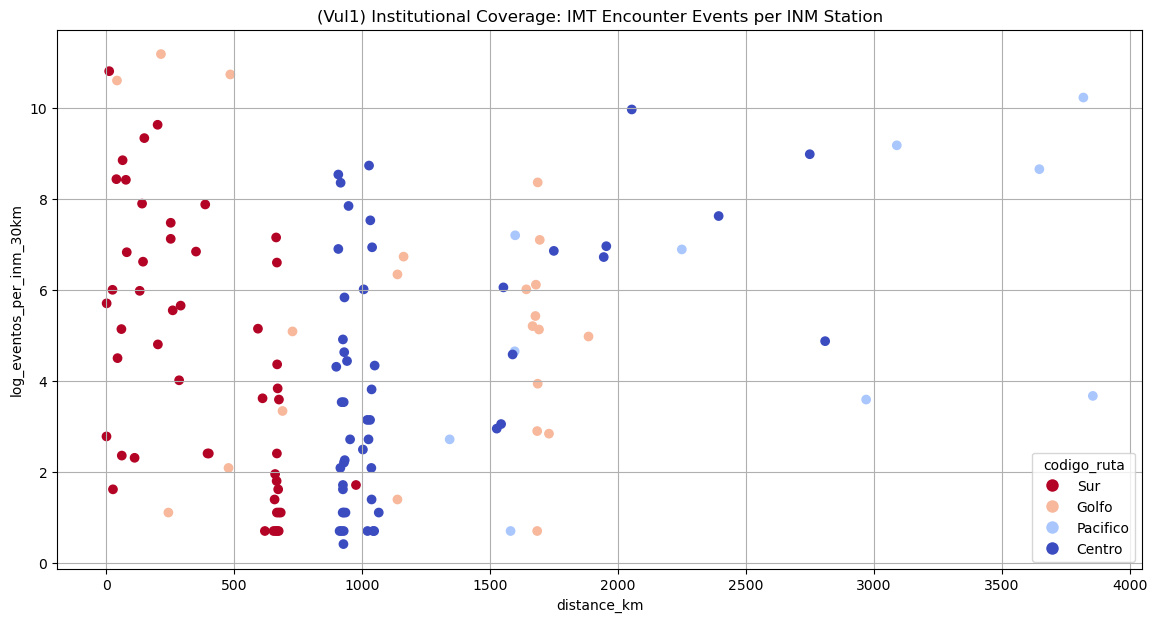

In [237]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura según sea necesario
plt.figure(figsize=(14, 7))

# Obtener los valores únicos de la columna 'codigo_ruta'
unique_routes = dfvalores['region'].unique()

# Crear un mapa de colores basado en el número de rutas únicas
colormap = plt.cm.get_cmap('coolwarm_r', len(unique_routes))

# Crear un diccionario para asignar un color a cada ruta
route_colors = {route: colormap(i) for i, route in enumerate(unique_routes)}

# Asignar colores a cada punto basado en su 'codigo_ruta'
colors = dfvalores['region'].map(route_colors)

# Graficar cada punto con el color correspondiente a su 'codigo_ruta'
plt.scatter(dfvalores['distance_km'], dfvalores['log_eventos_per_inm_30km'], 
            c=colors, marker='o', label='Data points colored by codigo_ruta')

# Añadir detalles al gráfico
plt.title('(Vul1) Institutional Coverage: IMT Encounter Events per INM Station')
plt.xlabel('distance_km')
plt.ylabel('log_eventos_per_inm_30km')
plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Crear una leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10, label=route) for i, route in enumerate(unique_routes)]
plt.legend(handles=handles, title='codigo_ruta')

# Mostrar la gráfica
plt.show()


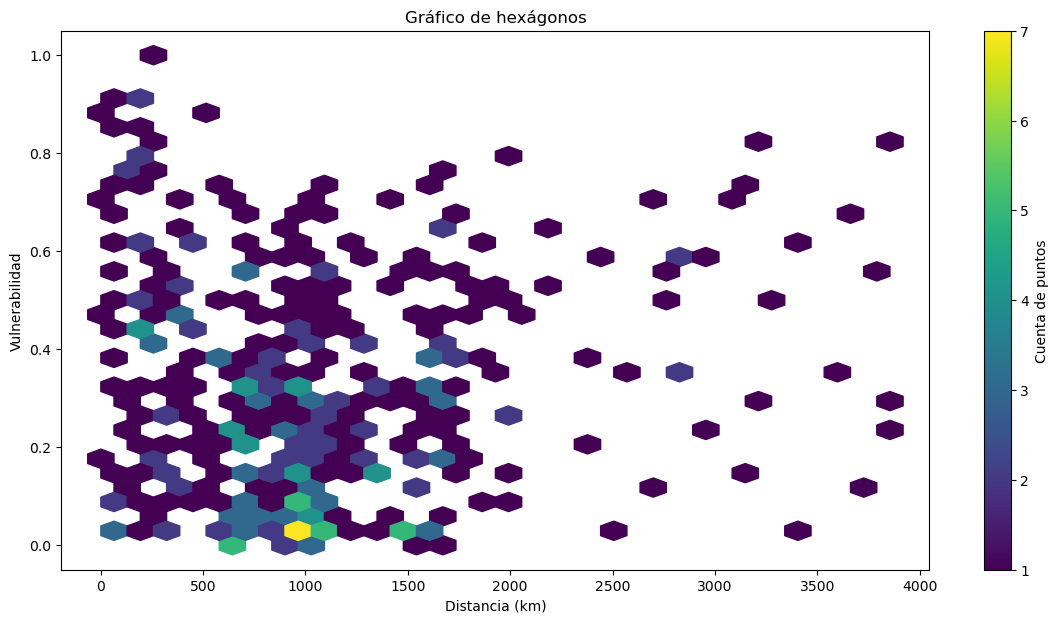

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.hexbin(dfvalores['distance_km'], dfvalores['norm_log_eventos_per_inm_30km'], gridsize=30, cmap='viridis', mincnt=1)
plt.colorbar(label='Cuenta de puntos')
plt.title('Gráfico de hexágonos')
plt.xlabel('Distancia (km)')
plt.ylabel('Vulnerabilidad')
plt.show()



La métrica busca capturar la relación entre la cantidad de eventos de migrantes detectados y la capacidad institucional disponible para manejar esos eventos. Aquí detallo los aspectos clave de la métrica hasta el momento:

Definición Original de ICI:
Inicialmente, el ICI se definió como el número de eventos registrados por cada institución en un radio de 30 km (INM y SC), proporcionando un ratio directo que reflejaba la presión sobre los recursos institucionales disponibles.

Ajustes Realizados:
Transformación Logarítmica:
Propósito: Para manejar mejor la distribución asimétrica de los datos y evitar la influencia desproporcionada de valores extremos en la métrica.
Método: Se aplicó 
log
⁡
(
1
+
�
)
log(1+x) a los ratios para suavizar la variación y estabilizar la varianza en los datos.
Normalización Min-Max:
Propósito: Escalar los valores transformados a una escala de 0 a 1, facilitando la comparación entre municipios.
Método: Se normalizaron los valores ajustados de modo que el valor mínimo corresponde a 0 y el máximo a 1.
Corrección de Laplace:
Para abordar el caso de municipios sin instituciones, se añadió 1 a los conteos de instituciones (suavización de Laplace), permitiendo calcular ratios incluso en ausencia de instituciones y evitando divisiones por cero.

Interpretación de la Métrica de Vulnerabilidad:
Valores Cercanos a 1: Indican una alta vulnerabilidad, reflejando una mayor cantidad de eventos por institución después de los ajustes. Esto sugiere que las instituciones en estos municipios están potencialmente sobrecargadas o insuficientes para gestionar el volumen de eventos.
Valores Cercanos a 0: Indican una menor vulnerabilidad, sugiriendo que la relación entre eventos e instituciones es más manejable.
Valor de 0 en la Métrica Ajustada: Específicamente señala a municipios sin instituciones disponibles, destacando una situación de alta vulnerabilidad, ya que no hay capacidad institucional registrada para atender ningún evento.
Uso y Aplicaciones:
Esta métrica puede ser utilizada por autoridades y organizaciones para:

Identificar áreas críticas que requieren atención inmediata o reasignación de recursos.
Planificar de manera más efectiva la distribución de recursos y la implementación de políticas.
Monitorear y evaluar el impacto de intervenciones y mejoras en la infraestructura y servicios a lo largo del tiempo.
La vulnerabilidad, tal como se ha modelado hasta ahora, proporciona una herramienta cuantitativa para evaluar y comparar la capacidad de respuesta institucional frente a los flujos migratorios, permitiendo así una gestión más informada y focalizada de los recursos en el contexto de la migración irregular.

### Vulnerabilidad 2

Exposición a Zona de Riesgo es una métrica diseñada para cuantificar y visualizar la exposición de las rutas migratorias a zonas de alto riesgo, considerando tanto la distancia de las rutas a estas zonas como la capacidad institucional disponible para mitigar dicho riesgo.

In [12]:
import pandas as pd
import numpy as np

In [13]:
segmentos = gpd.read_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp').to_crs(epsg=4485)

In [158]:
#segmentos.to_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp')

/var/folders/68/6zkv8z4j4rl6ds90br2rb7ph0000gn/T/ipykernel_14640/242722420.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  segmentos.to_file('/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/segmentos/segmentos.shp')


In [145]:
# Función para mapear la primera letra a la región correspondiente
def map_region(codigo):
    if pd.isna(codigo):
        return 'Desconocido'  # O cualquier valor que prefieras para los nulos
    elif codigo.startswith('S'):
        return 'Sur'
    elif codigo.startswith('G'):
        return 'Golfo'
    elif codigo.startswith('P'):
        return 'Pacifico'
    elif codigo.startswith('C'):
        return 'Centro'
    else:
        return 'Desconocido'  # Por si acaso hay un código que no coincide

# Crear la nueva columna 'region'
segmentos['region'] = segmentos['codigo_uni'].apply(map_region)

In [186]:
#print(segmentos)

In [177]:
# Eliminar las columnas especificadas del DataFrame 'segmentos'
columnas_a_eliminar = ['vulnerabilidad_origen','vulnerabilidad_destino']
segmentos = segmentos.drop(columns=columnas_a_eliminar)

In [178]:
segmentos.columns

Index(['Arc', 'Ciudad', 'Tipo', 'Municipio', 'distancia_', 'duration_t',
       'Corrupcion', 'CrimenOrg', 'CrimMujer', 'dist_ori', 'dist_des',
       'inm_30km', 'sc_30km', 'dur_ori', 'dur_des', 'codigo_uni', 'geometry',
       'distance_km', 'region'],
      dtype='object')

In [183]:
# Calcular la suma de las distancias totales de todos los arcos
suma_distancia_total = segmentos['distancia_'].sum()

# Función para calcular la vulnerabilidad para cada nodo y tipo de crimen
def calcular_vulnerabilidad(df, tipo_nodo, suma_distancia_total, columna_crimen):
    vulnerabilidad = []
    for idx, row in df.iterrows():
        if row['Tipo'] == tipo_nodo:
            arc = row['Arc']
            nodo = row['Ciudad']
            instituciones_nodo = row['sc_30km'] + 1
            distancia_total_arco = row['distancia_']
            
            df_arco = df[df['Arc'] == arc]
            
            crimen_dista_nodo = sum(
                (p[columna_crimen] / (p[f'dist_{tipo_nodo[:3]}'] + 1))
                for i, p in df_arco.iterrows()
            )
            
            vulnerabilidad_nodo = (crimen_dista_nodo * (distancia_total_arco / suma_distancia_total) * (1 / (instituciones_nodo + 1)))
            vulnerabilidad.append(vulnerabilidad_nodo)
        else:
            vulnerabilidad.append(0)
    return vulnerabilidad

# Calcular vulnerabilidad para nodos de origen y destino para cada tipo de crimen
for crimen in ['CrimMujer', 'CrimenOrg', 'Corrupcion']:
    segmentos[f'vul2_{crimen.lower()}_or'] = calcular_vulnerabilidad(segmentos, 'origen', suma_distancia_total, crimen)
    segmentos[f'vul2_{crimen.lower()}_des'] = calcular_vulnerabilidad(segmentos, 'destino', suma_distancia_total, crimen)

# Mostrar el DataFrame con las nuevas columnas de vulnerabilidad
print(segmentos[['Arc', 'Ciudad', 'Tipo', 'vul2_crimmujer_or', 'vul2_crimmujer_des', 'vul2_crimenorg_or', 'vul2_crimenorg_des', 'vul2_corrupcion_or', 'vul2_corrupcion_des']])



                Arc              Ciudad        Tipo  vul2_crimmujer_or  \
0     PG1529-PG1530   Suchiate, Chiapas      origen           0.000287   
1     PG1529-PG1530                   0  intermedio           0.000000   
2     PG1529-PG1530  Tapachula, Chiapas     destino           0.000000   
3     PG1530-PG1491  Tapachula, Chiapas      origen           0.002594   
4     PG1530-PG1491                   0  intermedio           0.000000   
...             ...                 ...         ...                ...   
1458  PG1772-PG1694                   0  intermedio           0.000000   
1459  PG1772-PG1694                   0  intermedio           0.000000   
1460  PG1772-PG1694                   0  intermedio           0.000000   
1461  PG1772-PG1694                   0  intermedio           0.000000   
1462  PG1772-PG1694     Merida, Yucatan     destino           0.000000   

      vul2_crimmujer_des  vul2_crimenorg_or  vul2_crimenorg_des  \
0               0.000000           0.000163 

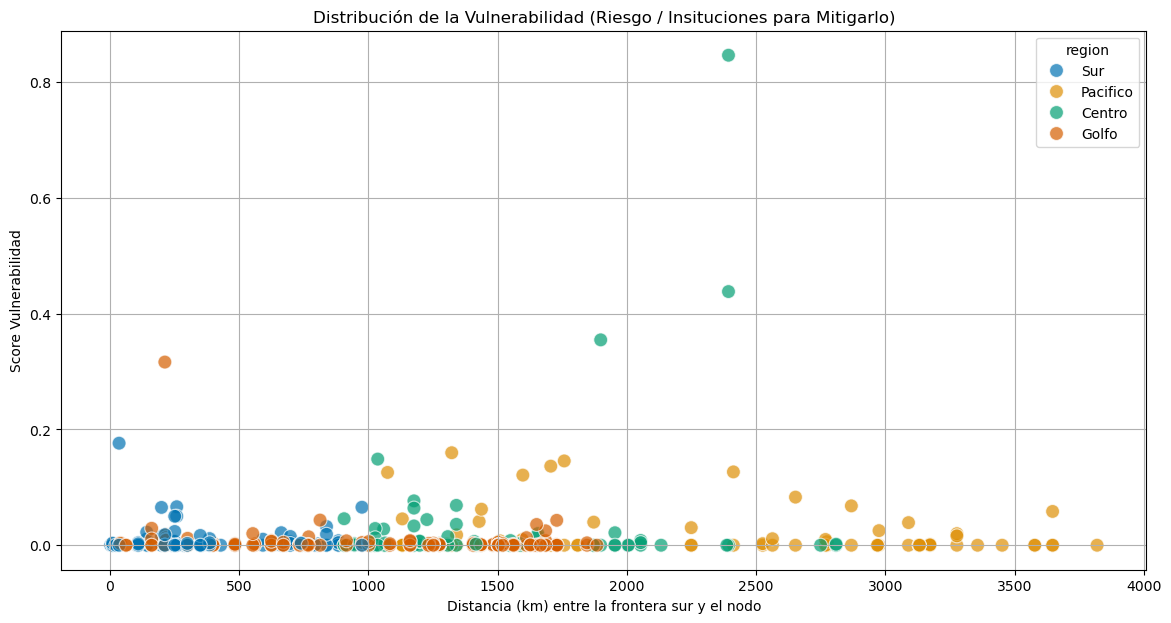

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar el DataFrame para excluir las filas donde 'region' es 'Desconocido'
segmentos_filtrado = segmentos[segmentos['region'] != 'Desconocido']

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el scatter plot utilizando seaborn para un manejo fácil de los colores por categoría
sns.scatterplot(data=segmentos_filtrado, x='distance_km', y='vul2_crimmujer_or', hue='region', palette='colorblind', s=100, alpha=0.7)

# Añadir detalles al gráfico
plt.title('Distribución de la Vulnerabilidad (Riesgo / Insituciones para Mitigarlo)')
plt.xlabel('Distancia (km) entre la frontera sur y el nodo')
plt.ylabel('Score Vulnerabilidad')
plt.grid(True)  # Añadir una cuadrícula para mejorar la legibilidad

# Mostrar la gráfica
plt.show()



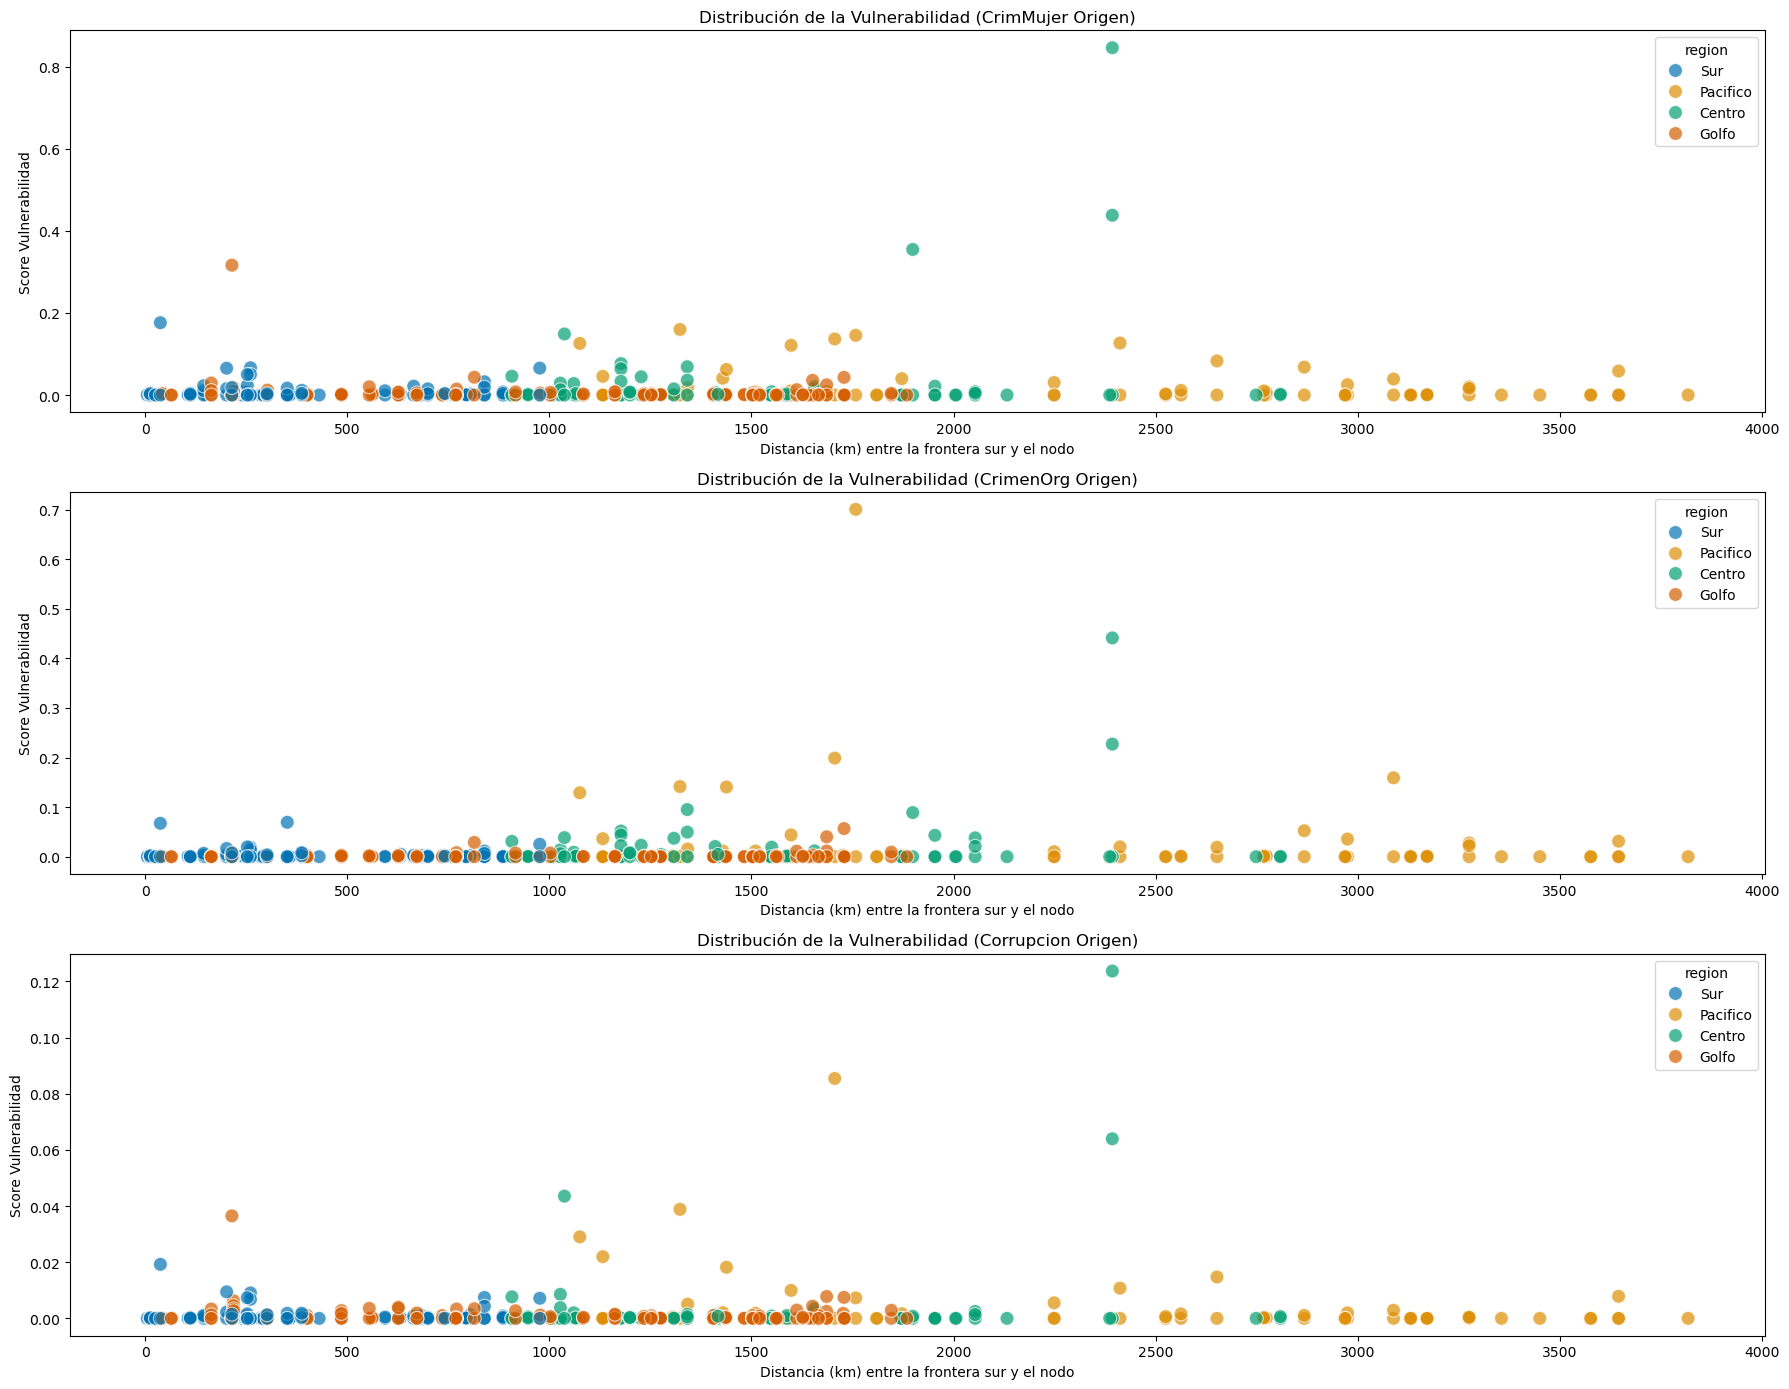

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar el DataFrame para excluir las filas donde 'region' es 'Desconocido'
segmentos_filtrado = segmentos[segmentos['region'] != 'Desconocido']

# Configurar el tamaño de la figura
plt.figure(figsize=(18, 14))

# Subplot 1: vul2_crimmujer_or
plt.subplot(3, 1, 1)
sns.scatterplot(data=segmentos_filtrado, x='distance_km', y='vul2_crimmujer_or', hue='region', palette='colorblind', s=100, alpha=0.7)
plt.title('Distribución de la Vulnerabilidad (CrimMujer Origen)')
plt.xlabel('Distancia (km) entre la frontera sur y el nodo')
plt.ylabel('Score Vulnerabilidad')

# Subplot 2: vul2_crimenorg_or
plt.subplot(3, 1, 2)
sns.scatterplot(data=segmentos_filtrado, x='distance_km', y='vul2_crimenorg_or', hue='region', palette='colorblind', s=100, alpha=0.7)
plt.title('Distribución de la Vulnerabilidad (CrimenOrg Origen)')
plt.xlabel('Distancia (km) entre la frontera sur y el nodo')
plt.ylabel('Score Vulnerabilidad')

# Subplot 3: vul2_corrupcion_or
plt.subplot(3, 1, 3)
sns.scatterplot(data=segmentos_filtrado, x='distance_km', y='vul2_corrupcion_or', hue='region', palette='colorblind', s=100, alpha=0.7)
plt.title('Distribución de la Vulnerabilidad (Corrupcion Origen)')
plt.xlabel('Distancia (km) entre la frontera sur y el nodo')
plt.ylabel('Score Vulnerabilidad')

# Ajustar el layout
plt.tight_layout()
plt.show()


In [15]:
#arc_df = pd.read_csv("/Users/pablouriarte/Mapa_Migracion_Irregular_Mexico_Fresh/1. Mapas/1. Mapas/Metodo_1/procesamiento de rutas/arcos/arcos_rutas_a_pie.csv")
#arc_df.head()